In [12]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import re, random, pickle, glob, os, difflib
import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utils import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from sklearn import metrics
import sklearn
import Bio

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7" 

In [13]:
print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print(keras.__version__)
print(sklearn.__version__)
print(Bio.__version__)

2.3.1
1.18.5
1.1.3
2.4.0
0.23.2
1.78


In [3]:
train_root = 'train/'
test_root = 'test/'
model_root = 'models/'
plot_root = 'beta_plots/'
train_set = ['x10_reads.fa']
test_sets = ['test_easy_1.fa', 'test_easy_2.fa', 'test_intermidate_1.fa', 'test_intermidate_2.fa', 'test_difficult_1.fa', 
             'test_difficult_2.fa', 'test_very_difficult_1.fa', 'test_very_difficult_2.fa']

In [4]:
df = read_fasta(train_root + train_set[0])
train_reads_original = np.array(seqs2onehot(np.array(df.seqs)))
train_reads = np.delete(train_reads_original,3,axis=2)
train_reads = np.expand_dims(train_reads, -1)
train_reads.shape

(169538, 150, 4, 1)

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        output = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return output

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 150 * 4
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -1*tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [7]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [19]:
width = 32
input_size = (150,4,1)
epochs = 150
batch_size = 2048 #1024
beta = 10e-2

In [20]:
ckpt_num = 'beta_vae'
ckpt_dir = os.path.join(model_root, ckpt_num, '')
if (os.path.isdir(ckpt_dir) == False):
    os.mkdir(os.path.join(ckpt_dir, ''))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 150, 4, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 75, 4, 256)   6400        input_11[0][0]                   
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 76800)        0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 256)          19661056    flatten_5[0][0]                  
____________________________________________________________________________________________

83/83 [==============================] - 14s 173ms/step - loss: 254.7660 - reconstruction_loss: 253.3098 - kl_loss: 14.5626
Epoch 97/150
83/83 [==============================] - 14s 172ms/step - loss: 262.3672 - reconstruction_loss: 260.9511 - kl_loss: 14.1603
Epoch 98/150
83/83 [==============================] - 14s 173ms/step - loss: 255.4316 - reconstruction_loss: 254.0733 - kl_loss: 13.5829
Epoch 99/150
83/83 [==============================] - 14s 173ms/step - loss: 254.3897 - reconstruction_loss: 252.9491 - kl_loss: 14.4060
Epoch 100/150
83/83 [==============================] - 14s 173ms/step - loss: 254.4307 - reconstruction_loss: 252.9762 - kl_loss: 14.5443
Epoch 101/150
83/83 [==============================] - 14s 173ms/step - loss: 257.8858 - reconstruction_loss: 256.4643 - kl_loss: 14.2154
Epoch 102/150
83/83 [==============================] - 14s 173ms/step - loss: 253.7287 - reconstruction_loss: 252.2909 - kl_loss: 14.3785
Epoch 103/150
83/83 [==============================

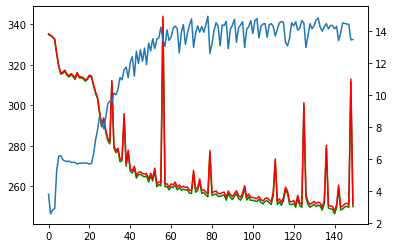

In [21]:
with strategy.scope():
    for width in [256]:
        for f_size in [6]:
            for latent_dim in [16]:
                filter_size = (f_size, 4)
                hist_path = os.path.join(model_root, ckpt_num, 'batch'+str(batch_size)+'_'+'width'+str(width)+'_'+'fsize'+str(f_size)+'_'+'latentdim'+str(latent_dim)+'_'+'beta'+str(beta)+'_'+'lr'+str(lr))
                encoder_inputs = keras.Input(shape=input_size)
                c1 = layers.Conv2D(width, filter_size, strides=(2, 1), activation="relu", padding="same")(encoder_inputs)
                x = layers.Flatten()(c1)
                x = layers.Dense(width, activation="relu")(x)
                z_mean = layers.Dense(latent_dim, name="z_mean")(x)
                z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
                z = Sampling()([z_mean, z_log_var])
                encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
                print(encoder.summary())

                latent_inputs = keras.Input(shape=(latent_dim,))
                x = layers.Dense(75 * 4 * width, activation="relu")(latent_inputs)
                x = layers.Reshape((75, 4, width))(x)
                x = layers.Conv2DTranspose(width, filter_size, strides=(2, 1), activation="relu", padding="same")(x)
                decoder_outputs = layers.Conv2D(1, filter_size, activation="sigmoid", padding="same")(x)
                decoder = keras.Model([latent_inputs], decoder_outputs, name="decoder")
                print(decoder.summary())

                vae = VAE(encoder, decoder, beta)
                vae.compile(optimizer=keras.optimizers.Adam(0.001))
                history = vae.fit(train_reads, epochs=epochs, batch_size=batch_size, verbose =1)
                with open(hist_path, 'wb') as f:
                    pickle.dump(history.history, f)
                

                fig, ax1 = plt.subplots()
                ax1.plot(history.history['reconstruction_loss'], color='green')
                ax1.plot(history.history['loss'], color='red')


                ax2 = ax1.twinx()
                ax2.plot(history.history['kl_loss'])
                plot_path = os.path.join(plot_root, str(f_size)+'_'+str(latent_dim)+'_loss''.png')
                plt.savefig(plot_path)
                
                easy_1 = assign_labels(read_fasta(test_root + test_sets[0]))
                test_reads_1 = np.array(seqs2onehot(np.array(easy_1.seqs)))
                test_reads_1 = np.delete(test_reads_1, 3, axis=2)
                test_reads_1 = np.expand_dims(test_reads_1, -1)
                r1 = vae.predict(test_reads_1, verbose=1)
                l = keras.losses.binary_crossentropy(test_reads_1, r1)
                pred = tf.reduce_mean(l, [1,2])
                auc = metrics.roc_auc_score(np.array(easy_1.viral), np.array(pred))
                
                model_path = os.path.join(model_root, ckpt_num, 'width'+str(width)+'_'+'fsize'+str(f_size)+'_'+'latentdim'+str(latent_dim)+'_'+'beta'+str(beta)+'_'+str(auc))
                vae.save(model_path, save_format='tf')

In [7]:
easy_1 = assign_labels(read_fasta(test_root + test_sets[0]), True)
test_reads_1 = np.array(seqs2onehot(np.array(easy_1.seqs)))
test_reads_1 = np.delete(test_reads_1, 3, axis=2)
test_reads_1 = np.expand_dims(test_reads_1, -1)

(105492, 2)


In [15]:
r1 = vae.predict(test_reads_1, verbose=1)

3297/3297 [==============================] - 12s 4ms/step
